OBJETIVO:

El texto procede de mensajes de twitter. Aqui se va a explorar distintas predictoras que podrian usarse para hacer el clasificador de sentimiento.
Entre estas posibles variables predictoras estan:
-  Emoticonos
-  Tags
- diferentes aspectos del lenguaje como el numero de palabras,digitos, exclamaciones, etc...

RESULTADO: aparentemente ninguna de estas caracteristicas supone un buen predictor.  
Por lo tanto en gran medida dependera de las palabras que se elijan como predictoras.


In [ ]:
import os
import numpy as np
import pandas as pd
import utilities_dataset as uta
import re
#Automcompletar rápido
%config IPCompleter.greedy=True

import nltk
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer=WordNetLemmatizer()

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns

path_stopwords = raiz+"/01_Documentos/stopwords.txt"
stopwords = [c.strip() for c in open(path_stopwords)]

In [ ]:
raiz= "C:/Proyectos/X01_sentiment_analyzer"
datos = uta.load_dataset_train(raiz=raiz)
datos_test = uta.load_dataset_val(raiz=raiz)

In [5]:
Y = datos['sentiment'].copy()
X = datos[['text']].fillna("-").copy()

# FUNCIONES

In [ ]:
def estadisticos_cont(num):
    #Calculamos describe
    estadisticos = num.describe().T
    #Añadimos la mediana
    estadisticos['median'] = num.median()
    #Reordenamos para que la mediana esté al lado de la media
    estadisticos = estadisticos.iloc[:,[0,1,8,2,3,4,5,6,7]]
    #Lo devolvemos
    return(estadisticos)

# EDA

## Tag vs Sentimiento

In [ ]:
def get_tag(text):
    return ' '.join([tag for word,  tag in nltk.pos_tag(nltk.word_tokenize(text))])

dff = X["text"].apply(get_tag)
cv = CountVectorizer( **{"ngram_range":(1, 1), "stop_words": "english", "lowercase":False})
dff_aux = cv.fit_transform(dff)
dff_cv = pd.DataFrame.sparse.from_spmatrix(dff_aux,columns = cv.get_feature_names_out().tolist(),index=Y.index  )

columns = dff_cv.columns
for column in columns :
    dff_cv[column] = dff_cv[column].astype("int")
df_tag = pd.concat([dff_cv,Y],axis=1)
df_tag.head()

In [84]:
df_tag.groupby("sentiment").agg("mean")

,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,...,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WRB
sentiment,,,,,,,,,,,,,,,,,,,,,
negative,0.345154,0.193308,0.831242,0.016367,0.007820,1.064557,1.197309,0.032370,0.018913,0.000000,...,0.033824,0.803783,0.415348,0.400800,0.224223,0.642480,0.346608,0.027460,0.050736,0.092926
neutral,0.324058,0.224149,0.801734,0.020448,0.004788,1.067814,0.955481,0.035848,0.019542,0.000259,...,0.030154,0.770545,0.350459,0.340494,0.167594,0.517277,0.268280,0.023683,0.052802,0.080497
positive,0.313592,0.188488,0.890368,0.013143,0.002828,1.044751,1.326402,0.036433,0.036100,0.000166,...,0.037431,0.739478,0.354683,0.334054,0.145899,0.589752,0.265014,0.019963,0.040426,0.056729


algunos buenos predictores de sentimiento

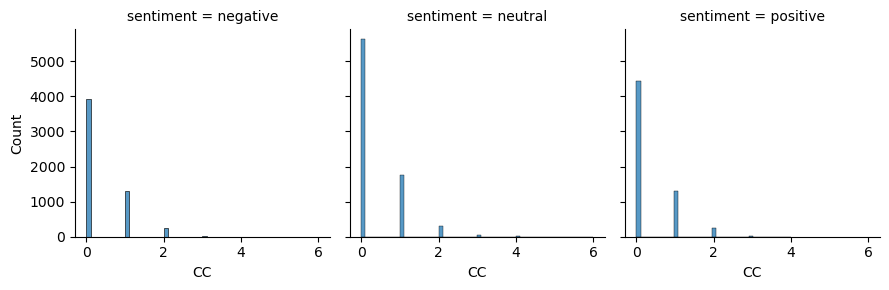

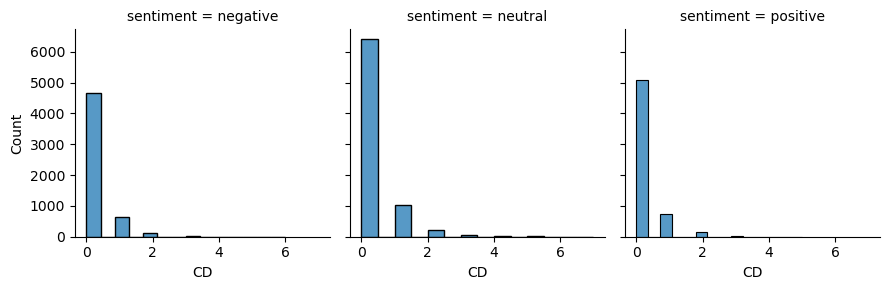

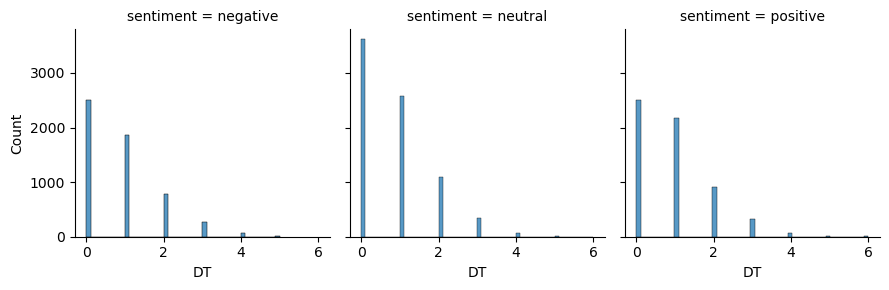

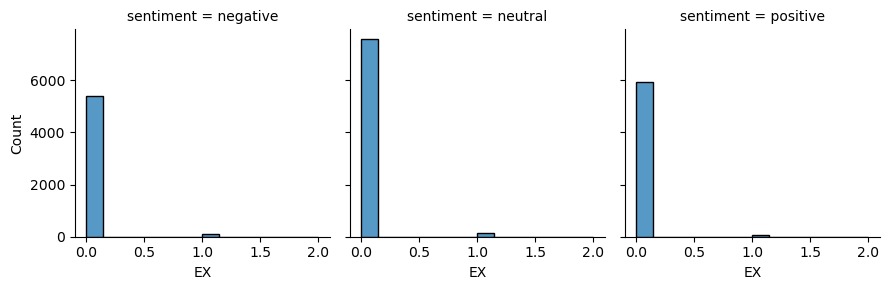

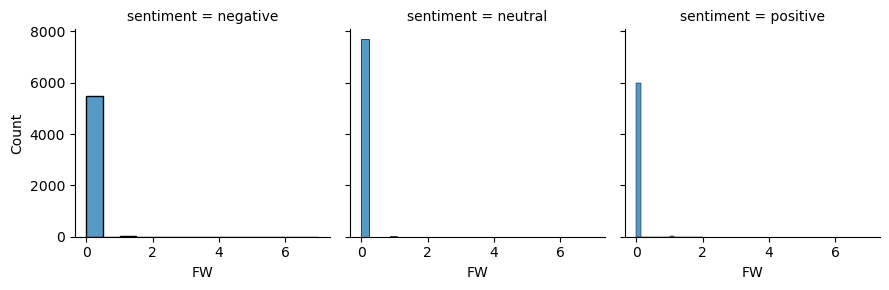

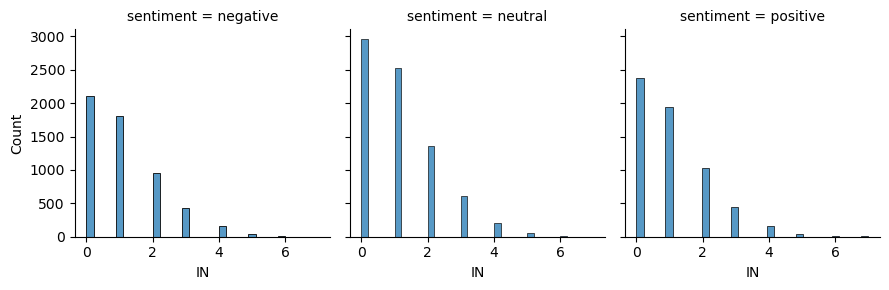

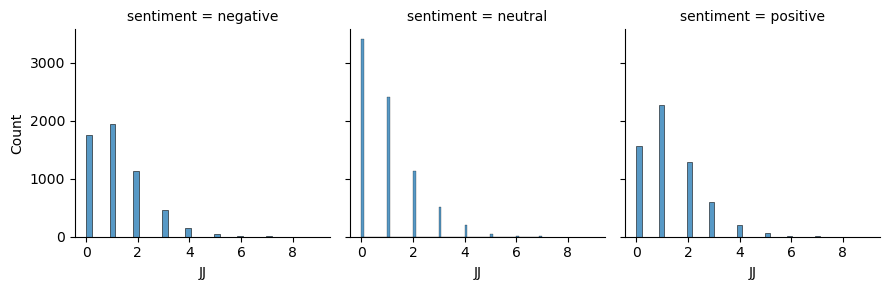

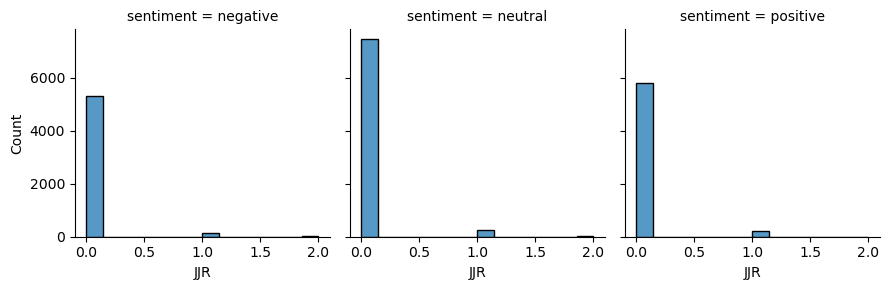

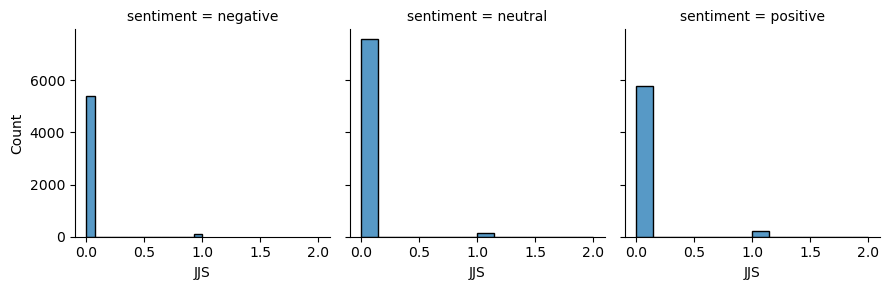

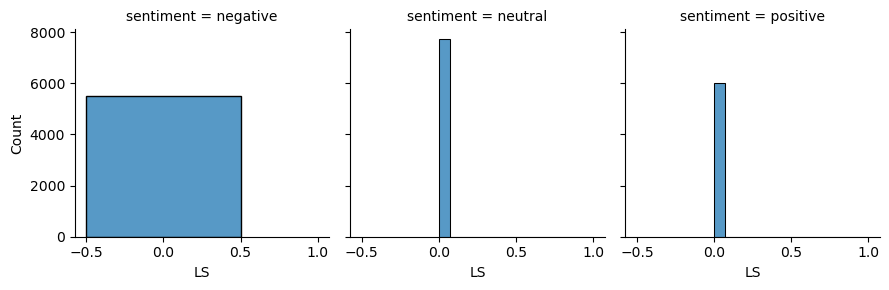

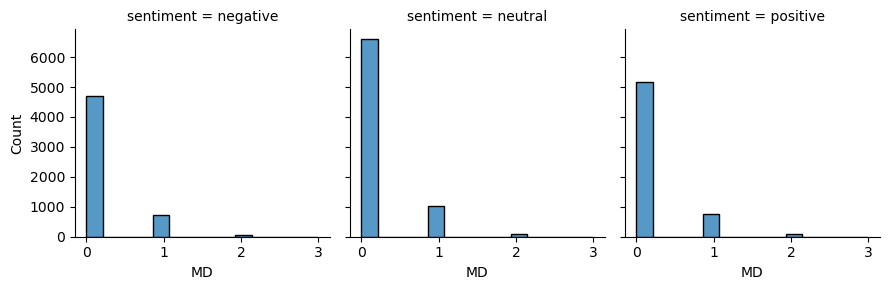

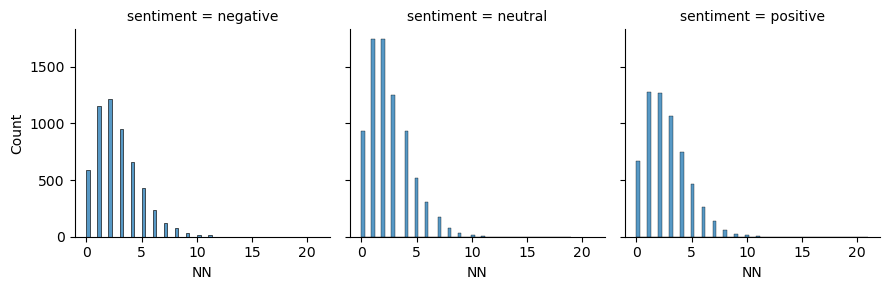

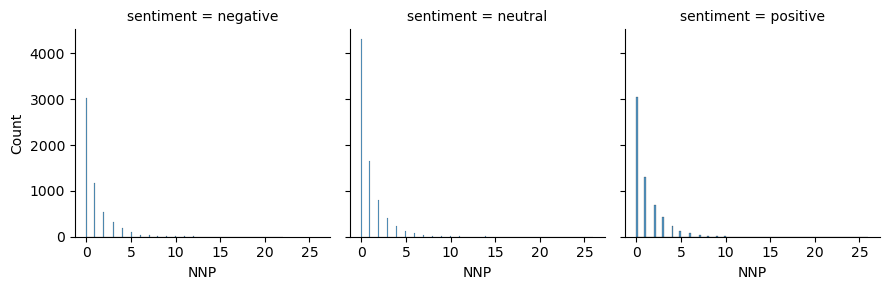

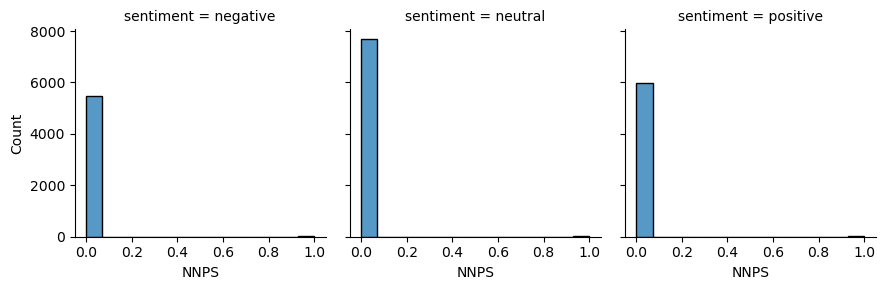

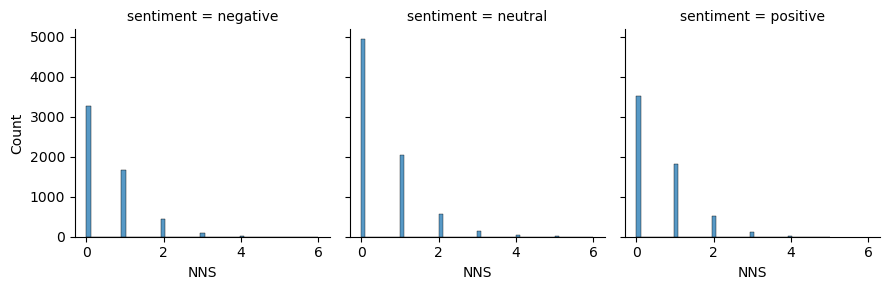

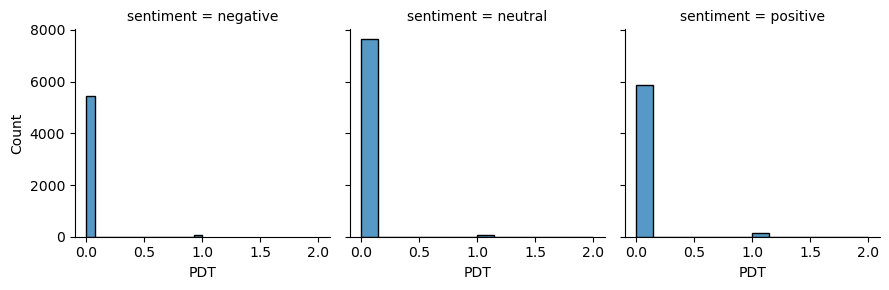

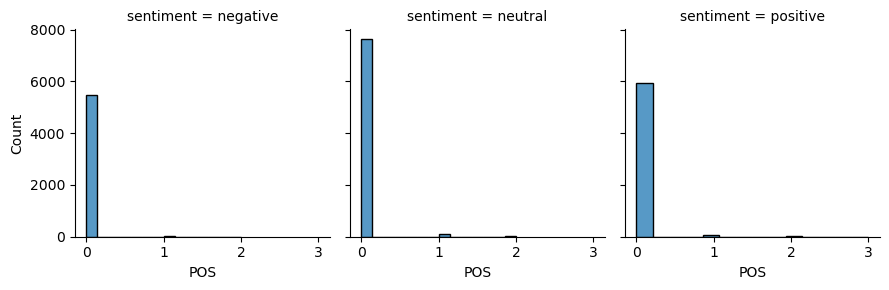

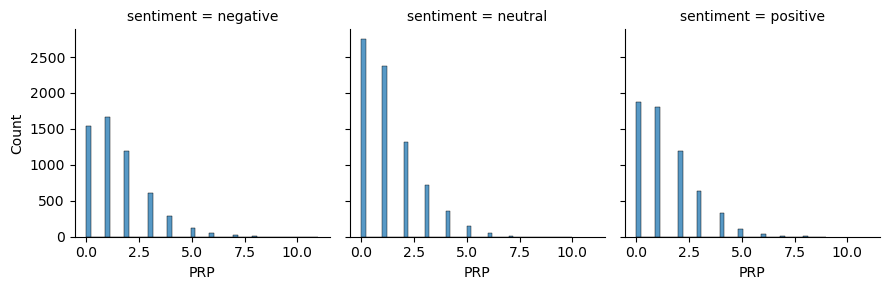

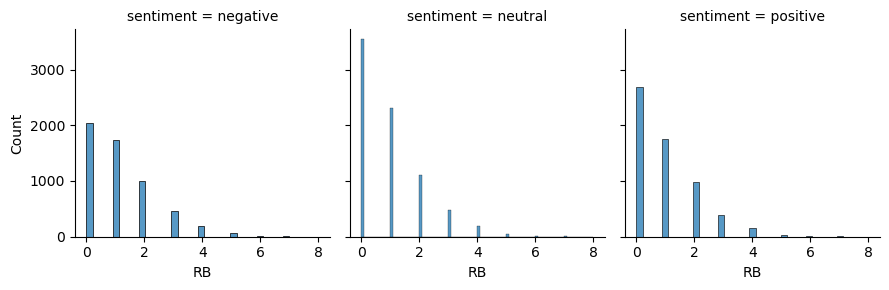

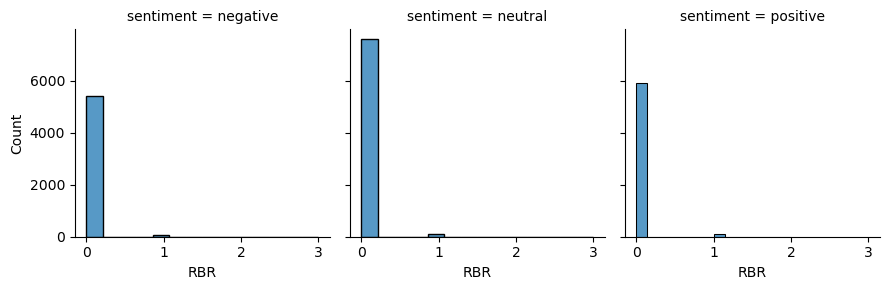

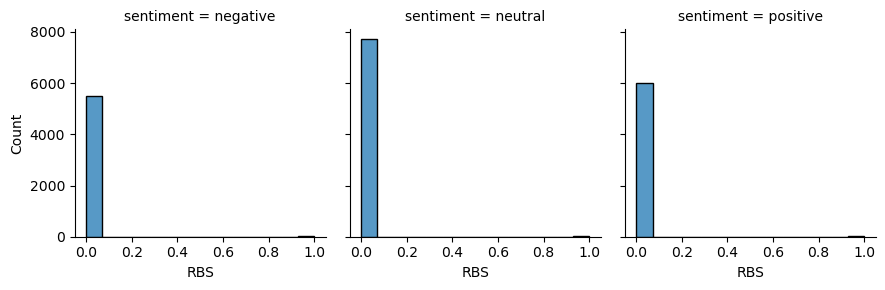

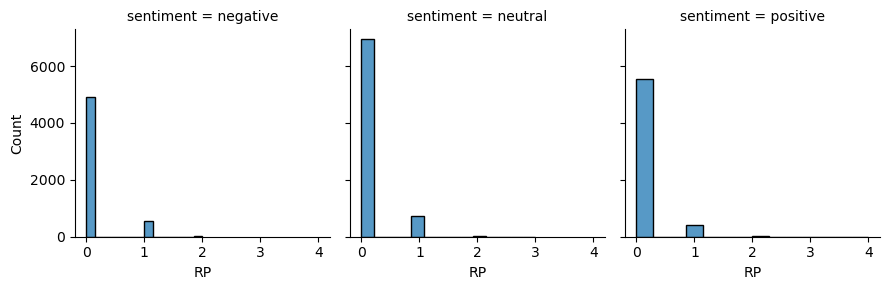

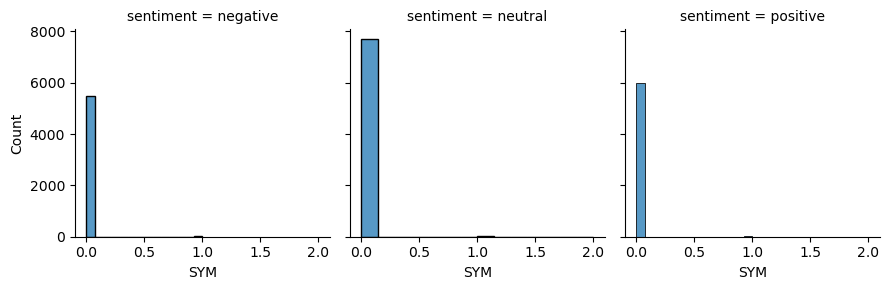

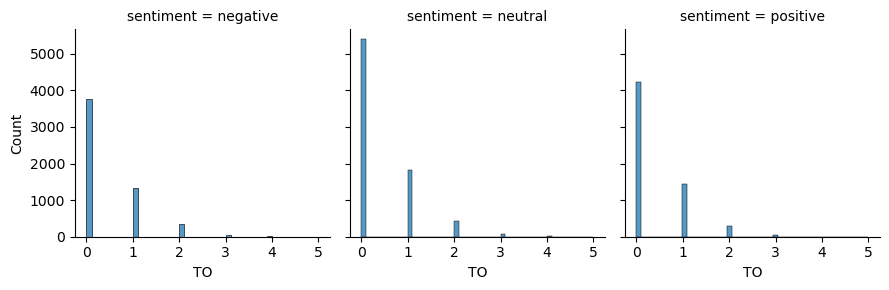

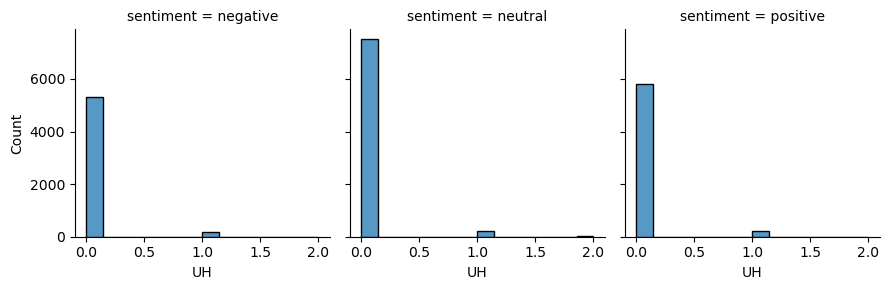

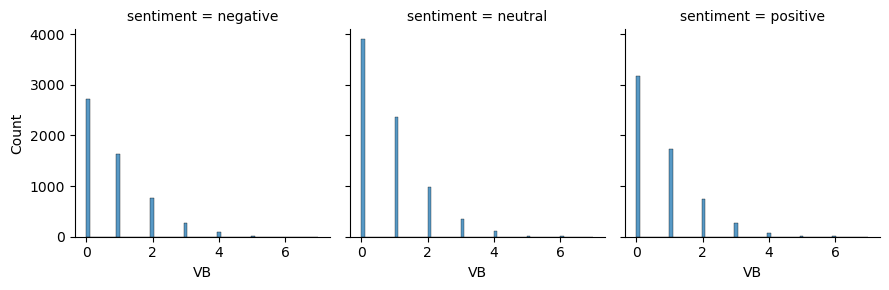

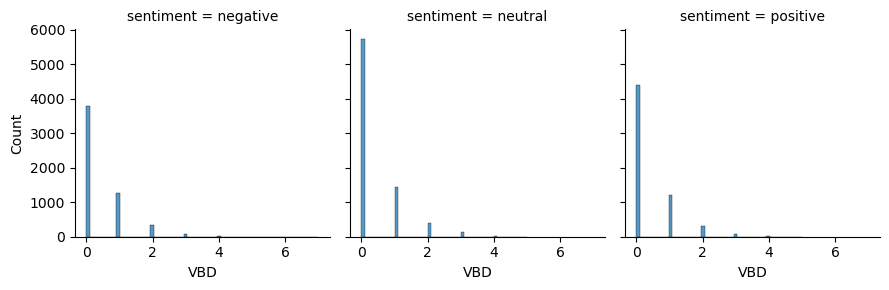

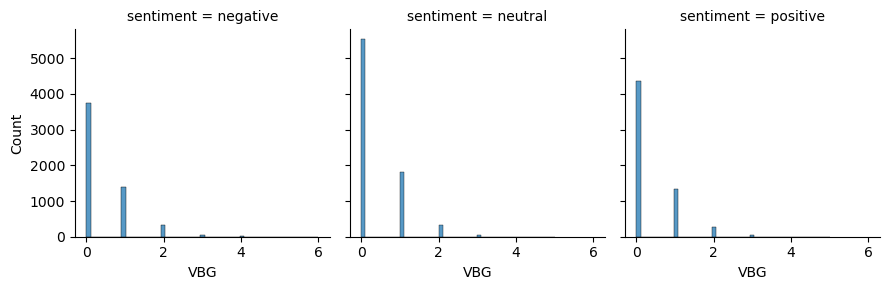

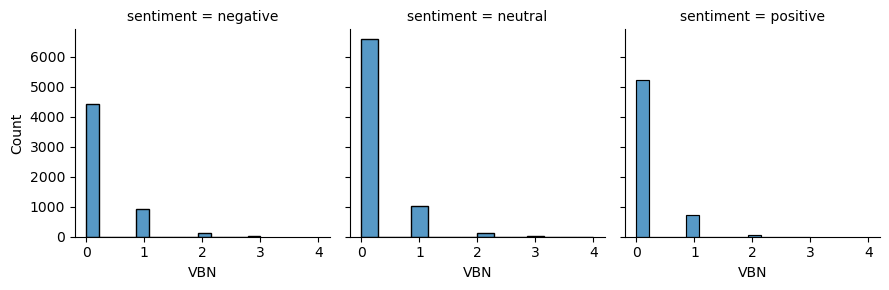

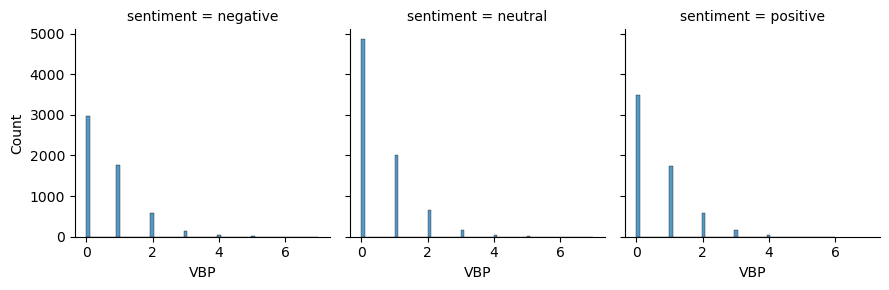

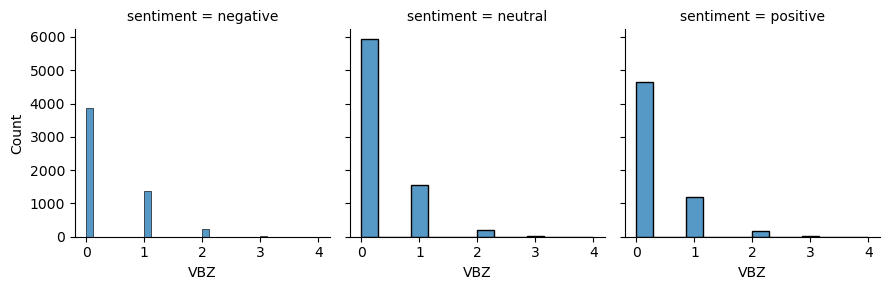

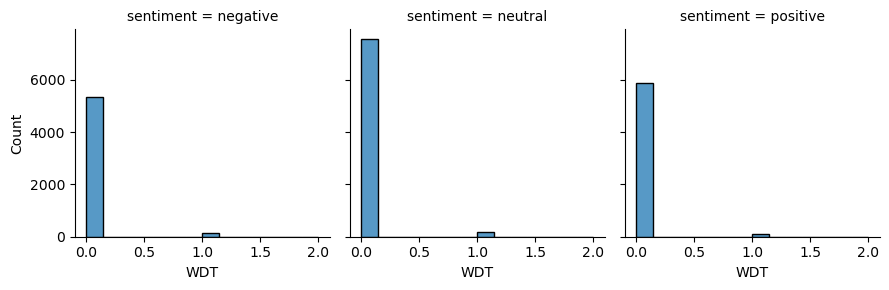

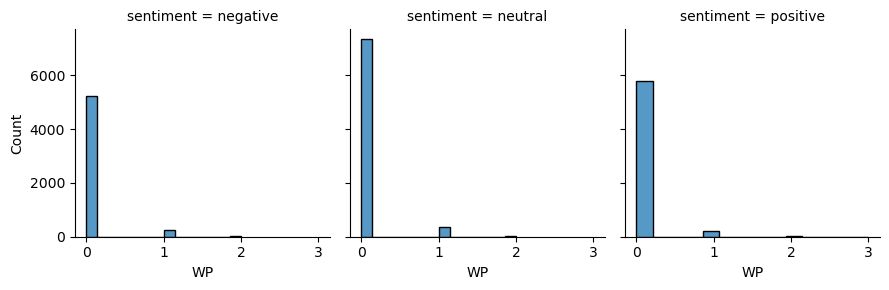

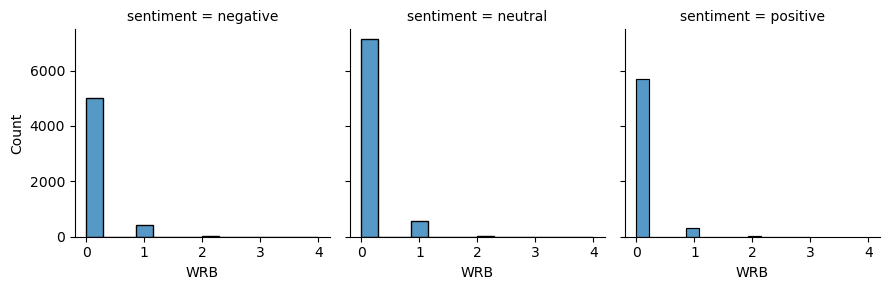

In [152]:

for cada, variable in enumerate(df_tag.columns[:-1]):
       
        g = sns.FacetGrid(df_tag, col="sentiment")
        g.map_dataframe(sns.histplot, x=variable)
        plt.show()

la mayoria de los tag no tiene nigun elemento en las frase.  
Los que si tienen no aportan grander diferencias cualitativas entre sentimiento.  
Esto quiere decir que no hay grandes diferencias en la forma de la distribucion.
No parece que sean buenos predictores

## Exploracion del lenguaje
Se va a explorar como se relaciona con el sentimiento las siguientes variables predictoras por cada tweet:
- Numero de palabras
- Numero de menciones 
- Numero de hastags
- Numero de palabras que empiecen en mayusculas
- Numero de signos de exclamacion o pregunta
- Numero de urls en el texto

In [112]:
    def count_regex( pattern, tweet):
        return len(re.findall(pattern, tweet))
    

    def transform( X, **transform_params):
        count_words = X.apply(lambda x: count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: count_regex(r'http.?://[^\s]+[\s]?', x))
        count_numbers = X.apply(lambda x: count_regex(r"\d+", x))

        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_numbers': count_numbers
                          })
        return df
        

In [113]:
df_analyst = transform( X["text"])
estadisticos_cont(df_analyst)

dff = pd.concat([df_analyst,Y],axis=1)
assert dff.shape[0] == df_analyst.shape[0]

In [114]:
#no veo nada claro
estadisticos_cont(df_analyst)

,count,mean,median,std,min,25%,50%,75%,max
count_words,19237.0,13.429069,12.0,7.215472,0.0,8.0,12.0,19.0,71.0
count_mentions,19237.0,0.003015,0.0,0.054828,0.0,0.0,0.0,0.0,1.0
count_hashtags,19237.0,0.022457,0.0,0.173388,0.0,0.0,0.0,0.0,5.0
count_capital_words,19237.0,0.258824,0.0,1.057121,0.0,0.0,0.0,0.0,26.0
count_excl_quest_marks,19237.0,0.713677,0.0,1.712232,0.0,0.0,0.0,1.0,98.0
count_urls,19237.0,0.045485,0.0,0.213303,0.0,0.0,0.0,0.0,4.0
count_numbers,19237.0,0.253054,0.0,0.665527,0.0,0.0,0.0,0.0,10.0


In [117]:
df_analyst.columns

Index(['count_words', 'count_mentions', 'count_hashtags',
       'count_capital_words', 'count_excl_quest_marks', 'count_urls',
       'count_numbers'],
      dtype='object')

In [119]:
df_agregado = dff.groupby("sentiment").agg(["mean"])
df_agregado.columns = df_analyst.columns
df_agregado

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_numbers
sentiment,,,,,,,
negative,13.921622,0.003273,0.021458,0.254955,0.655574,0.028369,0.222586
neutral,12.895561,0.003106,0.023424,0.246668,0.628963,0.056037,0.288210
positive,13.664282,0.002662,0.022126,0.277990,0.875728,0.047579,0.235734


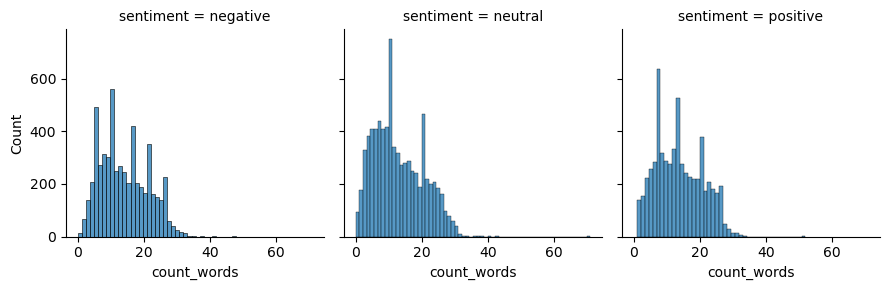

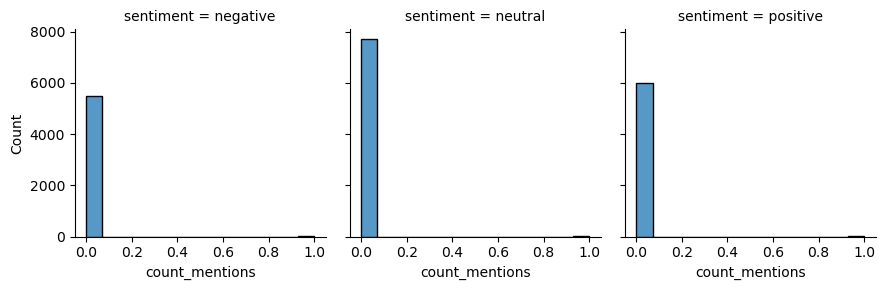

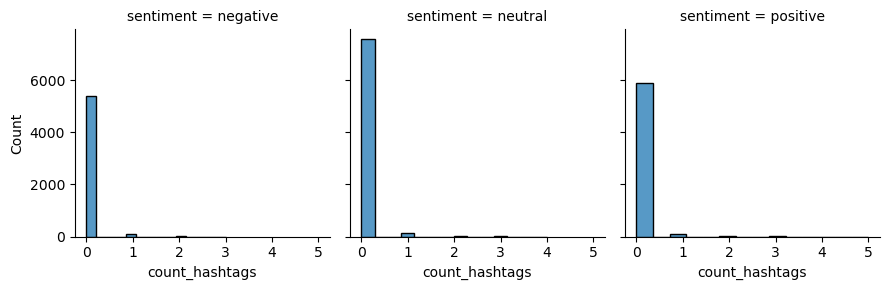

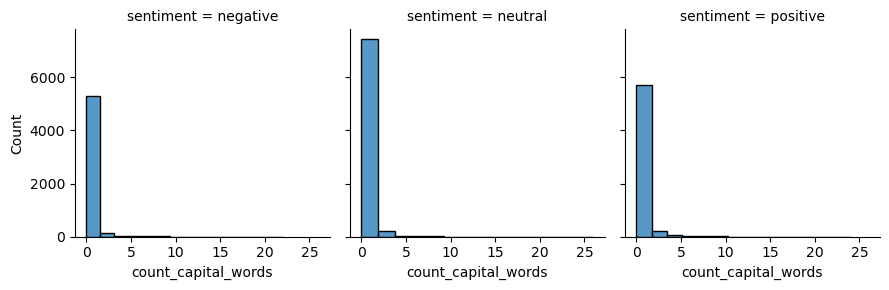

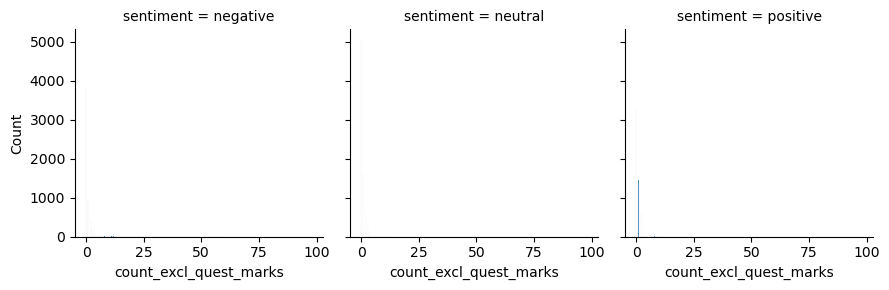

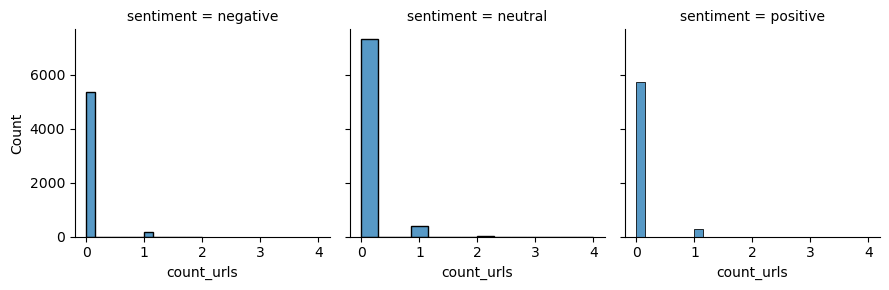

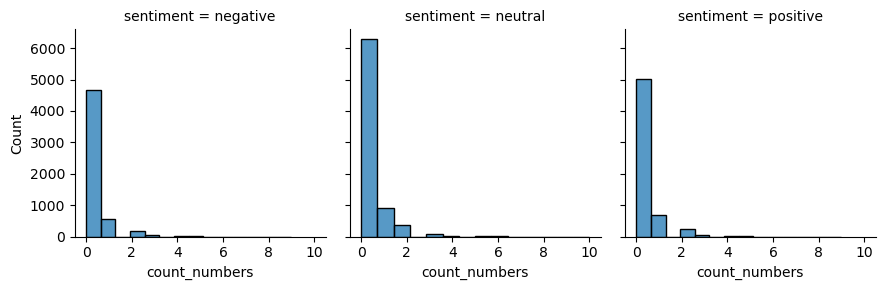

In [154]:

for cada, variable in enumerate(dff.columns[:-1]):
       
        g = sns.FacetGrid(dff, col="sentiment")
        g.map_dataframe(sns.histplot, x=variable)
        plt.show()

las distribuiones se superponen perfectamente. No van a ser grander predictoras. Quiza aportar algo marginalmente

# Emoticonos
Se va ha estudiar si los emoticonos tienen alguna relacion con el sentimiento

In [158]:
def cambio_contracciones_good(text):
    emo_repl = {
         # positive emoticons
         " &lt;3 ": " emotigood ",
         " :d ": " emotigood ", # :D in lower case
         " :dd ": " emotigood ", # :DD in lower case
         " 8\\) ": " emotigood ",
         " :-\\) ": " emotigood ",
         " :\\) ": " emotigood ",
         " ;\\) ": " emotigood ",
         " \\(-: ": " emotigood ",
         " \\(: ": " emotigood ",
         " x[dD] ": " emotigood ",
    }
         
    emo_repl_order =  [k for (k_len,k) in reversed(sorted([(len(k),k) for k in emo_repl.keys()]))]
    for k in emo_repl_order:
        # text = re.sub().replace(k, emo_repl[k])
        text = re.sub(k,  emo_repl[k], text)
    return text

def cambio_contracciones_bad(text):
    emo_repl = {
      
         # negative emoticons:
         " :/ ": " emotibad ",
         " :&gt; ": " emotibad ",
         " :'\\)": " emotibad ",
         " :-\\( ": " emotibad ",
         " :\\( ": " emotibad ",
         " [Tt]_[Tt] ":" emotibad ",
         " :S " : " emotibad ",
         " :-S ": " emotibad ",
     }
    emo_repl_order =  [k for (k_len,k) in reversed(sorted([(len(k),k) for k in emo_repl.keys()]))]
    for k in emo_repl_order:
        # text = text.replace(k, emo_repl[k])
        text = re.sub(k,  emo_repl[k], text)
    return text

In [160]:
df_emogood = X["text"].apply(lambda x: cambio_contracciones_good( x)).apply(lambda x: count_regex( "emotigood", x) )
df_emogood.name = "emotigood"
df_emobad = X["text"].apply(lambda x: cambio_contracciones_bad( x)).apply(lambda x: count_regex( "emotibad", x) )
df_emobad.name = "emotibad"
df_emo = pd.concat([df_emogood,df_emobad,Y],axis=1)

In [164]:
df_emo.describe().T

,count,mean,std,min,25%,50%,75%,max
emotigood,19237.0,0.004003,0.066353,0.0,0.0,0.0,0.0,2.0
emotibad,19237.0,0.001092,0.034561,0.0,0.0,0.0,0.0,2.0


In [168]:
df_emo.groupby("sentiment").agg(["mean"])

,emotigood,emotibad
,mean,mean
sentiment,,
negative,0.002364,0.002182
neutral,0.003235,0.001035
positive,0.006488,0.000166


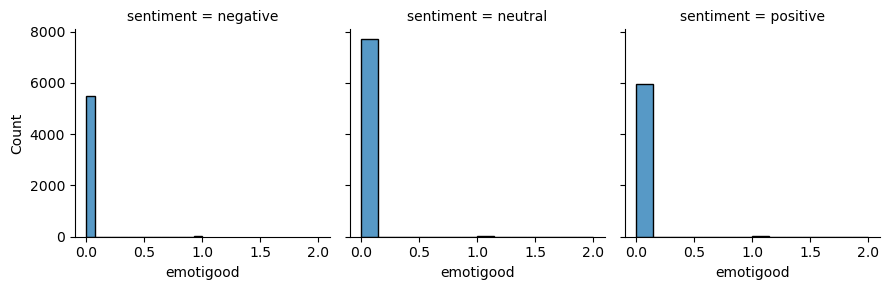

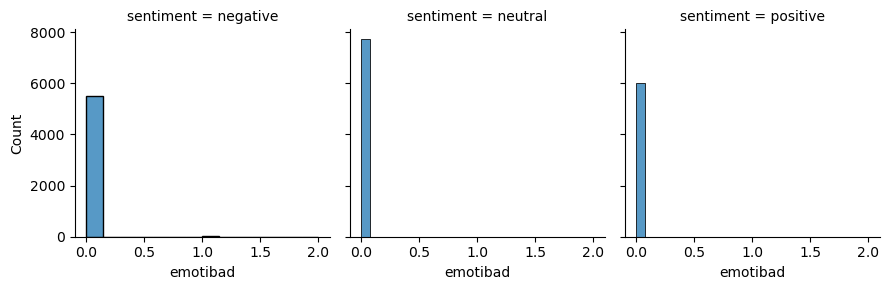

In [162]:

for cada, variable in enumerate(df_emo.columns[:-1]):
       
        g = sns.FacetGrid(df_emo, col="sentiment")
        g.map_dataframe(sns.histplot, x=variable)
        plt.show()

No parece un buen predictor de sentimiento , hay muy pocos 